# Instancia de librarias

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# import datetime as dt
from datetime import datetime # Trabajar con fechas

# Metricas de desempeño de modelos 
import scipy.stats as stats
import statistics
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler  # Estandarización de los datos
from sklearn.model_selection import cross_val_score

# Series de tiempo
from statsmodels.tsa.seasonal import seasonal_decompose # graficas de estacionalidad y tendencia
from statsmodels.tsa.stattools import adfuller # prueba 
from statsmodels.tsa.statespace.sarimax import SARIMAX #SARIMAX
import pmdarima as pm # autoarima
# import statsmodels.formula.api as smf

# Formato de visualización por centenas
pd.options.display.float_format = '{:,.2f}'.format

# Graficas
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set_theme(color_codes=True)

# Tamaño del cuadro de las gráficas por defult
plt.rcParams["figure.figsize"] = (12,6)

# import plotly.graph_objects as go
# from plotly.subplots import make_subplots


print("Setup complete")

Setup complete


# Importación de datos

In [2]:
path = r'E:\\skillsForIndustry/project_wallmart/data/Walmart_Store_sales.csv'
wall_data = pd.read_csv(path, header=0, encoding='utf-8')

In [3]:
wall_data['Date'] = pd.to_datetime(wall_data['Date'],format="%d-%m-%Y",dayfirst=True)
wall_data.info()
wall_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,"1,643,690.90",0,42.31,2.57,211.10,8.11
1,1,2010-02-12,"1,641,957.44",1,38.51,2.55,211.24,8.11
2,1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11
3,1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11
4,1,2010-03-05,"1,554,806.68",0,46.50,2.62,211.35,8.11


#### Frecuencia de tiempo

In [4]:
stores = wall_data
stores = stores.iloc[:,[1,0,2]]
stores = stores.groupby(['Date','Store'])['Weekly_Sales'].sum().reset_index()
stores['Store'] = stores.Store.astype(str)
stores.columns = ['Date','Store','Weekly_Sales']
stores.head()
# stores.info()

,Date,Store,Weekly_Sales
0,2010-02-05,1,"1,643,690.90"
1,2010-02-05,2,"2,136,989.46"
2,2010-02-05,3,"461,622.22"
3,2010-02-05,4,"2,135,143.87"
4,2010-02-05,5,"317,173.10"


In [5]:
num_store = stores['Store'].unique()
num_store

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45'],
      dtype=object)

In [6]:
sem = {}
for store in num_store:
    df = stores[stores['Store']==store].copy()
    df.drop('Store',axis=1, inplace=True)
    sem[store] = df
    df.set_index('Date',inplace=True)
    
# Elegir una tienda    
# semana['20']

In [7]:
# semana['20']

#### Performance

In [8]:
def performance(a,b):
    print('Mean Absolute Error: ',metrics.mean_absolute_error(a,b))
    print('Mean Square Error: ',metrics.mean_squared_error(a,b))
    print('Root Mean Square Error: ',np.sqrt(metrics.mean_squared_error(a,b)))
    print('Mean Absolute Percentage Error: ', metrics.mean_absolute_percentage_error(a,b))
    
    plt.figure(figsize=(10,8),dpi=60)
    sns.regplot(b,a);
    
# def cross_validation(model,a,b):
#     cv = cross_val_score(model,a,b,cv=10,scoring='r2')
#     print(f'Cross validation: {cv.mean()*100}%')

#### ADF

In [9]:
def adf(series,column_name):
    print(f'Resultados ADF: ,{column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used', 'Observation number'])
    for key, value in dftest[4].items():
        dfoutput['Critical Values (%s)'%key] = value
    print(dfoutput)
    if ((dftest[1] > 0.00) & (dftest[1] <= 0.05)):
        print('Los datos son estacionarios')
    else:
        print('Los datos no son estacionarios')

#### Diferencias

In [10]:
def dif(st):
    prev_values = st.Weekly_Sales.shift()
    dif = st.Weekly_Sales - prev_values
    dif.plot()

#### Estacionalidad

In [11]:
def estacionalidad(st):
    est = seasonal_decompose(st.iloc[1:],model='additive',period = 52)
    est.plot();

#### Conjunto de entrenamiento y test

In [12]:
def tra_tes(st,period):
    train = st.Weekly_Sales[:len(st.Weekly_Sales)-period]  # primero datos
    test = st.Weekly_Sales[len(st.Weekly_Sales)-period:]   # últimos datos
    return train,test

## Semanal y tiendas

In [13]:
s_20 =  sem['20'].rename_axis(index=None,columns=None)
s_14 =  sem['14'].rename_axis(index=None,columns=None) # No son datos estacionarios
s_13 =  sem['13'].rename_axis(index=None,columns=None)
s_10 =  sem['10'].rename_axis(index=None,columns=None)
s_27 =  sem['27'].rename_axis(index=None,columns=None)
s_26 =  sem['26'].rename_axis(index=None,columns=None)
s_23 =  sem['23'].rename_axis(index=None,columns=None)
s_24 =  sem['24'].rename_axis(index=None,columns=None)
s_39 =  sem['39'].rename_axis(index=None,columns=None)
s_39 =  sem['37'].rename_axis(index=None,columns=None)
s_30 =  sem['30'].rename_axis(index=None,columns=None)
s_31 =  sem['31'].rename_axis(index=None,columns=None)
s_44 =  sem['44'].rename_axis(index=None,columns=None)
s_19=  sem['19'].rename_axis(index=None,columns=None)
s_5 =  sem['5'].rename_axis(index=None,columns=None)

## Elegit tienda y periodicidad

In [14]:
st = s_20
periodos = 48

In [15]:
vnames = [name for name in globals() if globals()[name] is st]
# print(vnames[0])

Tienda: s_20


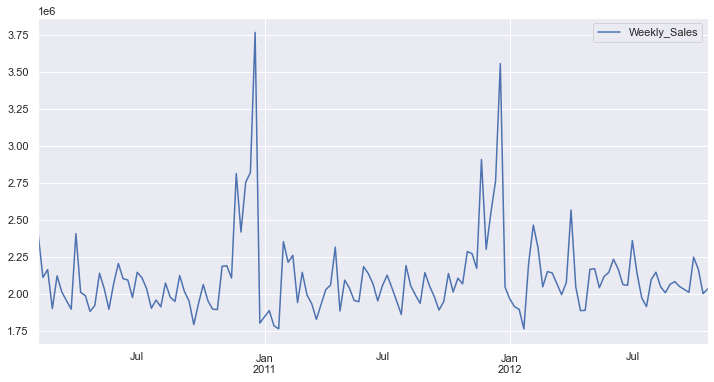

In [16]:
print('Tienda:',vnames[0])
st.plot();

#### Prueba  Dickey Fuller Aumentada (ADF)

In [17]:
adf(st.Weekly_Sales,'Weekly_Sales')

Resultados ADF: ,Weekly_Sales
Test Statistic           -5.39
p-value                   0.00
No Lags Used              4.00
Observation number      138.00
Critical Values (1%)     -3.48
Critical Values (5%)     -2.88
Critical Values (10%)    -2.58
dtype: float64
Los datos son estacionarios


Tienda: s_20


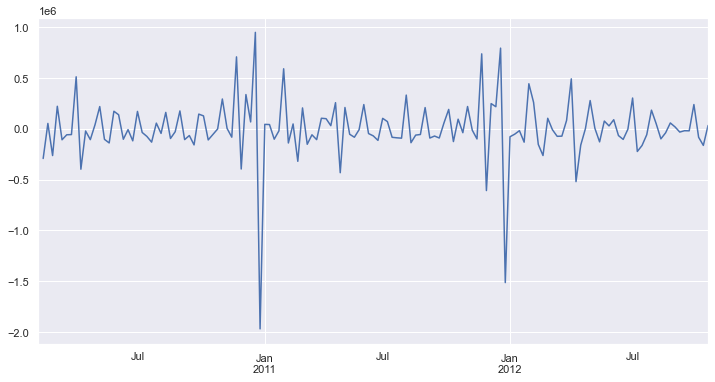

In [18]:
# prev_values = st.Weekly_Sales.shift()
# dif = st.Weekly_Sales - prev_values
# dif.plot()
print('Tienda:',vnames[0])
dif(st)

Tienda: s_20


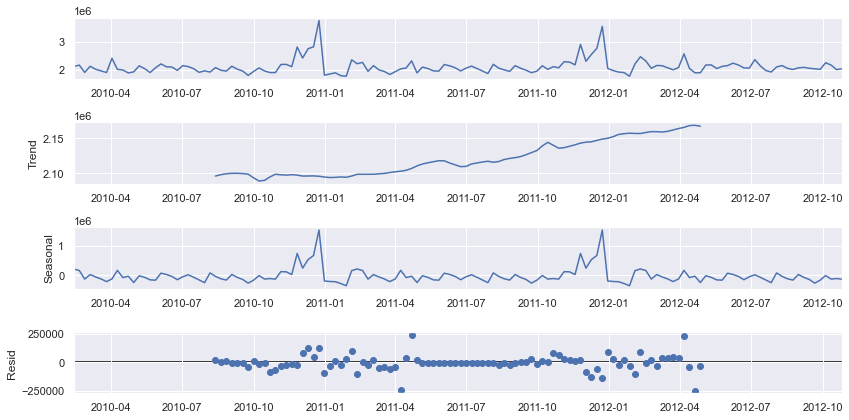

In [19]:
# differenced_store_20_dif = seasonal_decompose(st.iloc[1:],model='additive',period = 52)
# differenced_store_20_dif.plot();

# estacionalidad(tienda)
print('Tienda:',vnames[0])
estacionalidad(st)

### ARIMA

#### Entrenamiento y Test

Tienda: s_20


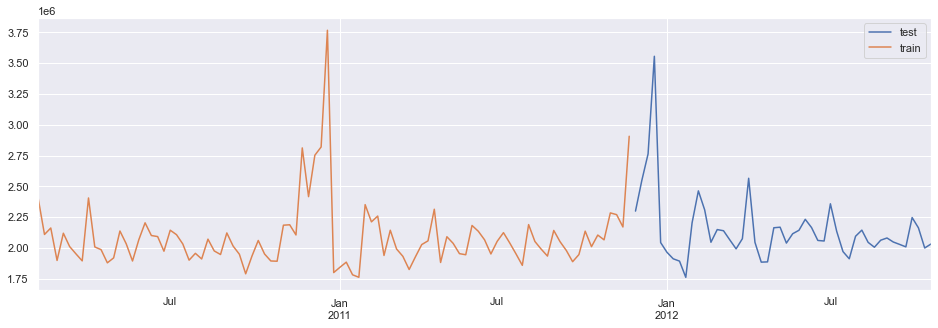

In [20]:
# train = s_20.Weekly_Sales[:len(s_20.Weekly_Sales)-periodos]  # primero datos
# test = s_20.Weekly_Sales[len(s_20.Weekly_Sales)-periodos:]   # últimos datos 

# periodos
# tra_tes(tienda,periodos)
train, test = tra_tes(st,periodos)
print('Tienda:',vnames[0])
test.plot(figsize=(16,5),legend=True, label='test')
train.plot(legend=True, label='train');


Tienda: s_20


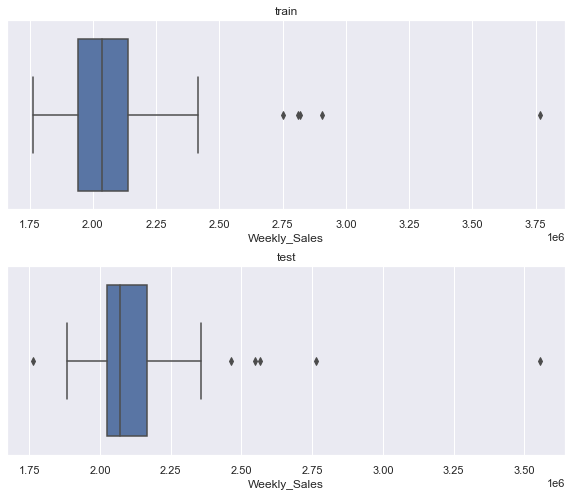

In [21]:
print('Tienda:',vnames[0])
fig, axs = plt.subplots(2,figsize=(10,8))
sns.boxplot(train, ax=axs[0]).set_title("train")
sns.boxplot(test, ax=axs[1]).set_title('test')
fig.subplots_adjust(hspace=0.3)

In [22]:
# Para determinar el train y el test, se sugiere que los datos asignados sean del 80% y 20% sucesivamente
# pero a mayor número de datos de entrenamiento, el AIC disminuye y el R2 aumenta
# caso contrario, el AIC aumenta y el R2 se hace negativo
# ¿De qué depende el periodo que se quiere calcular? Por ejemplo, yo determine 48 semanas que se quieren predecir
print(len(train),len(test))

95 48


In [23]:
# Nunca se debe utilizar toda la información de un dataset, debe ser el dataset de train 
# para el entrenamiento de los modelo.
# El test nunca filtra inforamción al train.

# D(e):parametro parte estacional, d(ne):parametro parte no estacional
e = 1
ne = 0
arima_model = pm.auto_arima(train, start_p=ne,d=ne,start_q=0,max_p=5,max_d=5,max_q=5,
                            start_P=0,D=e,start_Q=0,max_P=5,max_D=5,max_Q=5,m=52,
                            seasonal=True,error_Action='warn',trace=True,test='adf',
                            supress_warnings = True, stepwise=True, random_state=20,
                            n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1135.241, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1139.189, Time=0.88 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=1139.307, Time=0.77 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1153.186, Time=0.05 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=1137.210, Time=0.88 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=1137.210, Time=0.37 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=3.43 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=1137.192, Time=0.11 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=1137.314, Time=0.16 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=1139.263, Time=0.28 sec

Best model:  ARIMA(0,0,0)(0,1,0)[52] intercept
Total fit time: 6.998 seconds


#### SARIMAX

In [24]:
arima_model = SARIMAX(train,order=(0,0,0),seasonal_order = (0,1,0,52))     #AIC 1,153.186; D=1;d=0  /// tienda 20, periodos = 24,30,42,48->
# arima_model = SARIMAX(train,order=(1,0,1),seasonal_order = (0,1,2,52))     #AIC 1,951.457; D=1;d=0  /// tienda 20, periodos = 18
# arima_model = SARIMAX(train,order=(2,0,1),seasonal_order = (1,0,0,52))        # AIC 2,661.550 #d=0,D=0  /// no estacionario tienda 14
# arima_model = SARIMAX(train,order=(0,1,1),seasonal_order = (1,0,0,52))        # AIC 2,630.246 #d=1,D=0  /// no estacionario tienda 14
# arima_model = SARIMAX(train,order=(5,0,0),seasonal_order = (0,0,0,52))        # AIC 2,150.174 #d=0,D=0  /// no estacionario tienda 30
# arima_model = SARIMAX(train,order=(0,1,0),seasonal_order = (1,0,0,52))        # AIC 2,199.934 #d=1,D=0  /// no estacionario tienda 30
arima_model = SARIMAX(train,order=(4,0,0),seasonal_order = (0,0,1,52))        # AIC 2,097.063 #d=0,D=0  /// no estacionario tienda 44
# arima_model = SARIMAX(train,order=(1,1,0),seasonal_order = (0,0,1,52))        # AIC 2,135.395 #d=1,D=0  /// no estacionario tienda 44
arima_result = arima_model.fit() 
arima_result.summary()

C:\Users\Rodrigo Piña\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Rodrigo Piña\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Rodrigo Piña\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\Rodrigo Piña\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         Weekly_Sales   No. Observations:                   95
Model:             SARIMAX(4, 0, 0)x(0, 0, [1], 52)   Log Likelihood               -1319.601
Date:                              Sat, 10 Dec 2022   AIC                           2651.202
Time:                                      07:39:58   BIC                           2666.526
Sample:                                  02-05-2010   HQIC                          2657.394
                                       - 11-25-2011                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4917      0.069      7.148      0.000       0.357       0.627
ar.L2          0.2570      0.117      2.205      0.027       0.029       0.485
ar.L3          0.0246      0.158      0.156      0.876      -0.285       0.334
ar.L4          0.2196      0.081      2.704      0.007       0.060       0.379
ma.S.L52       0.5052      0.123      4.107      0.000       0.264       0.746
sigma2      7.184e+10   2.07e-12   3.47e+22      0.000    7.18e+10    7.18e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               395.28
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.91
Prob(H) (two-sided):                  1.00   Kurtosis:                        12.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.08e+39. Standard errors may be unstable.
"""

In [25]:
arima_result.model_orders
# r2. si no hay una cte (ar,phi_0) en el modelo. este es negativo.
# el autoarima no tiene una cte 

{'trend': 0,
 'exog': 0,
 'ar': 4,
 'ma': 0,
 'seasonal_ar': 0,
 'seasonal_ma': 52,
 'reduced_ar': 4,
 'reduced_ma': 52,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

In [26]:
arima_pred = arima_result.predict(start= len(train),end=len(st)-1,type='levels').rename('ARIMA Predictions')
arima_pred.head(8)

2011-12-02   2,524,922.11
2011-12-09   2,661,497.14
2011-12-16   2,629,897.12
2011-12-23   3,074,714.57
2011-12-30   2,251,848.38
2012-01-06   2,265,406.64
2012-01-13   2,270,043.23
2012-01-20   2,226,963.17
Freq: W-FRI, Name: ARIMA Predictions, dtype: float64

In [27]:
# len(arima_pred)
# len(train)
# len(s_20)
# len(test)
# len(train)-len(arima_pred)

Tienda: s_20


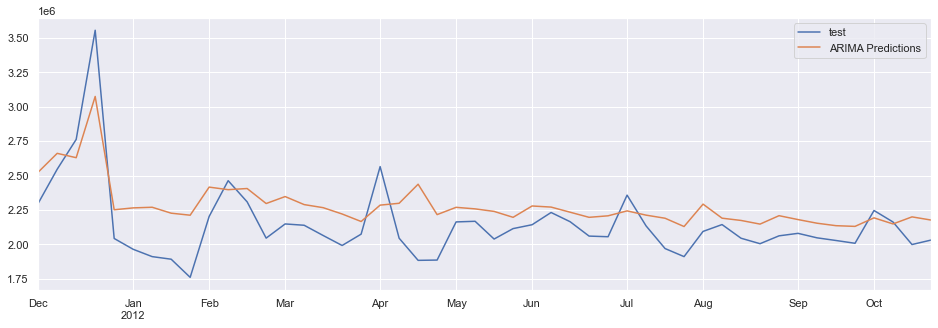

In [28]:
print('Tienda:',vnames[0])
test.plot(figsize=(16,5),legend=True,label='test')
arima_pred.plot(legend=True);

Tienda: s_20
Accuracy test(R2):  39.99891335420954
Mean Absolute Error:  180776.197829922
Mean Square Error:  45710543921.0651
Root Mean Square Error:  213800.24303322274
Mean Absolute Percentage Error:  0.08626597610259001


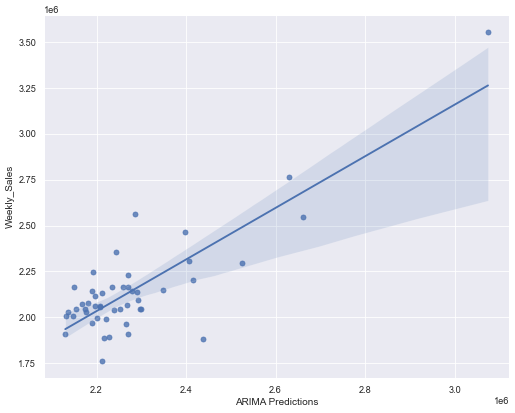

In [29]:
print('Tienda:',vnames[0])
print('Accuracy test(R2): ', metrics.r2_score(test,arima_pred)*100)
performance(test,arima_pred)